In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns


# Load Data

In [46]:
df = pd.read_csv('winemag-data_first150k.csv')

In [53]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [65]:
df['points'].nunique()

21

# Visualization 1

Text(0, 0.5, 'Average Price')

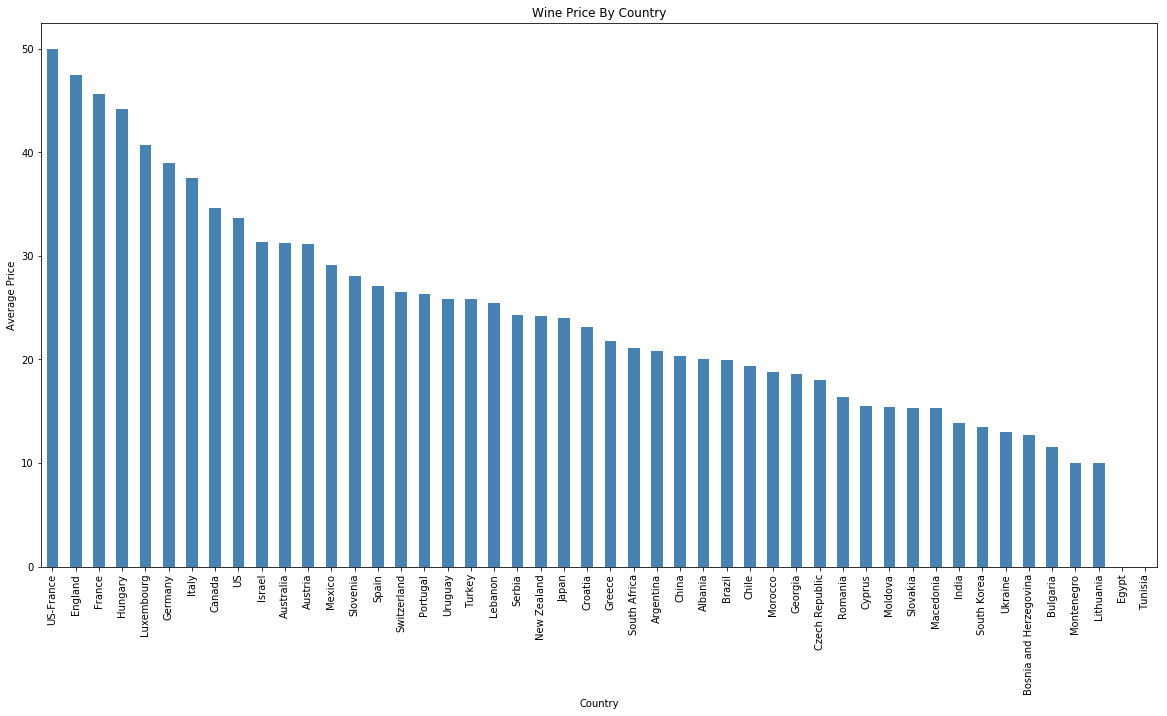

In [48]:
plt.figure(figsize=(20,10))

# group by year and calculate mean of open price
df.groupby(pd.Grouper(key='country')).mean()['price'].sort_values(ascending=False).plot.bar(color='steelblue')

# show labels 
plt.title('Wine Price By Country')
plt.xlabel('Country')
plt.ylabel('Average Price')

The most important attributes should be encoded with the most effective channels in order to be most noticeable and the most effective is aligned spatial position (VAD page 101) so I sort the mean of wine from high to low. The key attribute, country, separates the marks along the horizontal spatial axis. The value attribute, average price, expresses the value with aligned vertical spatial position and line marks.  
The bar plot shows that US-France has highest wine price than other countries.

# Visualization 2

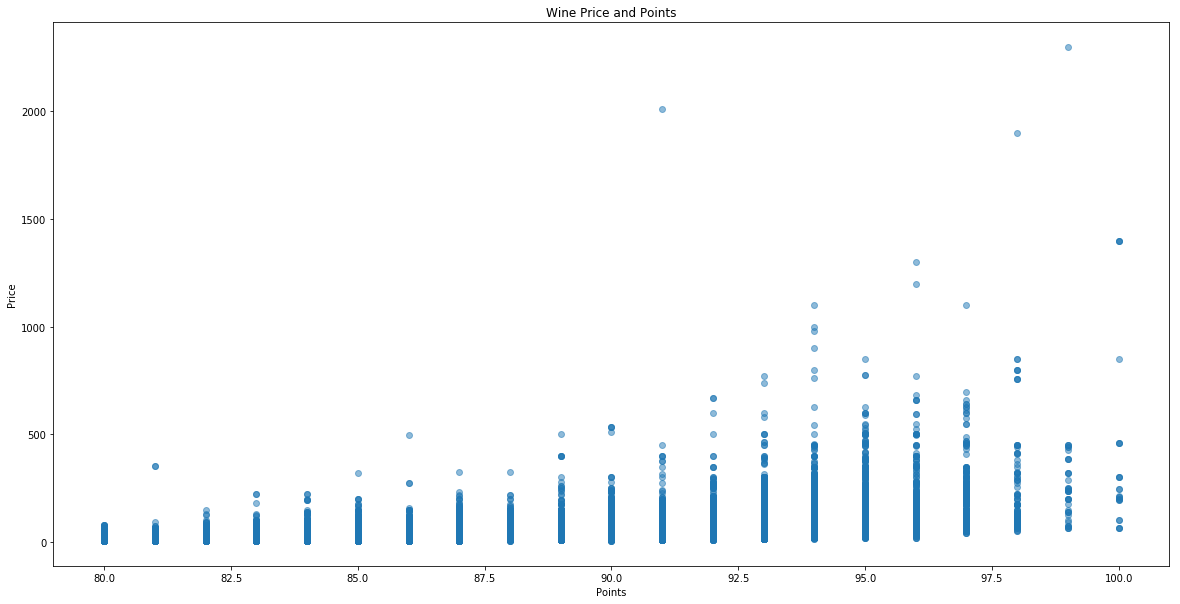

In [73]:
# scatter plot point and price
plt.figure(figsize=(20,10))
plt.scatter(df['points'], df['price'],alpha=0.5)
plt.title('Wine Price and Points')
plt.xlabel('Points')
plt.ylabel('Price')
plt.show()



I applied the scatter plot to show the relationship between
the price and point. The scatter plot expresses values with horizontal and vertical
spatial position and point marks and fulfill the task of finding trends, outliers, and
locate cluster(VAD page 148).
From the plot, we can tell that price is tend to be higher when points get higher.